In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, minimize

%load_ext autoreload
%autoreload 1
%aimport joint_proba

In [2]:
font_size = 12
plt.rc('font', size=font_size)
plt.rc('axes', titlesize=font_size)
plt.rc('axes', labelsize=font_size)
plt.rc('xtick', labelsize=font_size)
plt.rc('ytick', labelsize=font_size)
plt.rc('legend', fontsize=font_size)
plt.rc('figure', titlesize=font_size)

In [3]:
import pickle
# df = pd.read_csv('../datasets/D.txt', sep=';', index_col=0, parse_dates=True)
with open('../datasets/D.pkl', 'rb') as f:
    df = pickle.load(f)
df.head(2)

,wind speed (m/s),significant wave height (m)
time (YYYY-MM-DD-HH),,
1965-01-01 00:00:00,15.3839,3.9879
1965-01-01 01:00:00,15.4990,4.0086


In [4]:
self = joint_proba.Multivariate(df, condY_x=np.arange(1, 22))
self.fit()
# self.plot_diagnosis()

Fitting marginal X
Fitting marginal Y
Fitting discrete conditional Y
Fitting continuous conditional Y using bulk


## Predict method

In [ ]:
mrp = 50
range_ratio = 10

# MRP of independent Y for validation
y_mrp = self.y_dist.predict(mrp=mrp)

# Jagged contour
contour_jag = self._get_jaggaed_contour(mrp)

# Smooth contour
# Method 1: Using bulk fitting
contours_bulk = {}
for condY in self.condY_cont_dists_bulk:
    res = self._get_smooth_contour(condY, mrp)
    dist_name = res.pop('dist_name')
    contours_bulk[dist_name] = res
    
# Method 2: Using tail re-para

In [ ]:
def _get_repara_contour(self, mrp, range_ratio):
    df = self._get_condY_para_tail(mrp, range_ratio=10)
    condY_cont_dists_tail = self._fit_condY_cont(df)
    contours_tail = {}
    for condY in condY_cont_dists_tail:
        res = self._get_smooth_contour(condY, mrp)
        dist_name = res.pop('dist_name')
        contours_tail[dist_name] = res

    # Evaluate contour using the jagged contour and y_mrp
    err_emp, err_apex = [], []
    ct_emp = contour_jag['y_top']
    for dist_name, ct_tail in contours_tail.items():
        ct_pred = interp1d(
            ct_tail['x'], ct_tail['y_top']
        )(self.condY_x) 
        mse = np.mean((ct_pred - ct_emp) ** 2)
        err_emp.append(np.sqrt(mse))
        err_apex.append(np.abs(np.nanmax(ct_tail['y_top']) - y_mrp))
    df['err_emp'] = err_emp
    df['err_apex'] = err_apex
    df['err'] = df.loc[:,['err_emp', 'err_apex']].mean(axis=1)

    # Select good candidates
    df = df[df['err'] < df['err'].min() * 5]
    df = df.sort_values('err')
    contours_tail = {dist_name: ct for dist_name, ct in contours_tail.items() if dist_name in df.index}
    condY_cont_dists_tail = [condY for condY in condY_cont_dists_tail if condY.dist_name in df.index]
    return contours_tail, condY_cont_dists_tail

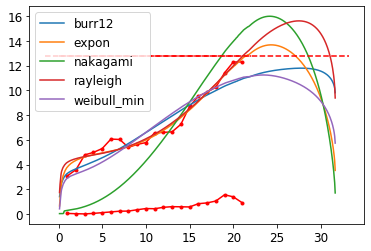

In [21]:
plt.plot(contour_jag['x'], contour_jag['y_top'], 'r.-')
plt.plot(contour_jag['x'], contour_jag['y_bot'], 'r.-')
plt.plot(plt.xlim(), [y_mrp, y_mrp], 'r--')
for dist_name, contour in contours_tail.items():
    plt.plot(contour['x'], contour['y_top'], label=dist_name)
#     plt.plot(self.x_pd.sample_coor, contour['contour_top'], h[0].get_color())
plt.plot(plt.xlim(), [y_mrp, y_mrp], 'r--')
plt.legend(loc='best')
plt.show()